## Grover's algorithm 

This notebook provides the basic deteails to understand **Grover's search algorithm for unstructured databases**, one of the prominent quantum algorithms with a **quadratic speed-up in computational complexity**. It leverages the fundamental principles of **quantum parallelism** through **quantum superposition** states. 

In this simple example, we will use $n=3$ qubits in order to demonstrate a database search over $2^n = 8$ elements. Through our oracle, we will mark one states of interest, which is being searched for during the algorithm exectution. The algorithm also works if multiple states are marked. 

Grover's algorithm has a **quadratic speedup in query complexity** compared to its classial counterpart, i.e., in Grover's algorithm, we need $\mathcal{O}(\sqrt{N})$ function evaluations to find the solution with high probability, while for a the classical worst case bound scales as $\mathcal{O}(N)$ with $N$ being the number of elements in the unstructured database (see Grover's original work: Lov K. Grover. 1996. A fast quantum mechanical algorithm for database search.), as in the worst case, we need to evaluate $N/2 +1$ times. For further details, consult the following reference: Nielsen, Michael A., and Isaac L. Chuang. Quantum computation and quantum information. Cambridge university press, 2010.

In [ ]:
#install the needed packages
!pip install qiskit --upgrade 
!pip install matplotlib
!pip install qiskit-aer --upgrade
!pip install --upgrade qiskit matplotlib


import matplotlib.pyplot as plt
import math
from qiskit import QuantumCircuit, transpile 
from qiskit.circuit.library import GroverOperator, MCMTGate, ZGate, MCMT
from qiskit.visualization import plot_distribution, plot_histogram
from qiskit_aer import AerSimulator

## 1. Prepare initial uniform superposition states of all database elements 

In order to leverage quantum parallelism through superposition, we first need to initialize a uniform quantum superposition states of all our $N=2^n$ database elements:

$$
 |start \rangle = H^{\otimes n} |0\rangle^{\otimes n}  = \frac{1}{\sqrt{N}} \sum_{j=0}^{N-1} |j\rangle =:  |\Psi_0 \rangle

$$

with $H$ being the Hadamard gate and $|0\rangle$ a computational basis state. 

Grover's algorithm has a nice geometric visualization. For this, we consider the space of solutions, i.e., our target state $|target\rangle$ and the non-solutions $|rest\rangle$. Both are orthogonal to each other, meanting that $ |target\rangle \perp |rest\rangle$. 

We can then express our uniform superposition "starting" state $| start \rangle $ as a linear combination of $|target\rangle$ and $|rest\rangle$, as they span our whole Hilbert space $\mathcal{H}$, i.e., $|start \rangle \in \{ |target \rangle, |rest \rangle \} = \mathcal{H}$:
$$
    | start \rangle = \sin (\frac{\theta}{2}) | target \rangle +  \cos (\frac{\theta}{2}) | rest \rangle
$$


In [25]:
def initialize_uniform_superposition(number_of_qubits=3):
    """
    Initialize a quantum circuit in a uniform superposition state.
    This function creates a quantum circuit with the specified number of qubits,
    applies the Walsh-Hadamard transform to each qubit, and returns the circuit.
    Args:
        number_of_qubits (int): The number of qubits to include in the circuit.
                                Default is 3.
    Returns:
        QuantumCircuit: A quantum circuit with n=number_of_qubits qubits in uniform superposition.
    """
    
    # Create a quantum circuit with 3 qubits
    qc = QuantumCircuit(number_of_qubits)
    
    # Apply Walsh-Hadamard transform to create uniform superposition
    for i in range(number_of_qubits):
        qc.h(i)
    
    return qc

#### Let's test our function that generates the quantum circuit for our initialization of the uniform superposition state for a given number of qubits:
We call our function ```initialize_uniform_superposition(number_of_qubits=3)``` and print the quantum circuit we defined.

In [26]:
# Draw the quantum circuit
initialize_uniform_superposition(number_of_qubits=3).draw()  

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     └───┘

## 2. Prepare the oracle for marking the target states

In this simple example, we have one target state, e.g. $|010\rangle$. For the case of $n=3$ we have prepared the uniform superposition state given by:
$$
     |\Psi_0 \rangle = \frac{1}{\sqrt{8}} (|000\rangle + |001\rangle + |010\rangle + |011\rangle + |100\rangle + |101\rangle + |110\rangle + |111\rangle)
$$
when applying the oracle $U_{O}$, we mark the state '010' by a phase and thus transform it to:
$$
     |\Psi_1 \rangle := \mathcal{O} |\Psi_0 \rangle = \frac{1}{\sqrt{8}} (|000\rangle + |001\rangle - |010\rangle + |011\rangle + |100\rangle + |101\rangle + |110\rangle + |111\rangle).
$$

Geometrically, we reflect our state around the axis given by $| rest \rangle$: 
$$
    | start \rangle = -\sin (\frac{\theta}{2}) | target \rangle +  \cos (\frac{\theta}{2}) | rest \rangle \text{ and } \theta =  2 \arcsin (\langle start | target \rangle ) =  2\arcsin \frac{1}{\sqrt{N}} .
$$
It is implemented by the following unitary $U_O =  \mathbb{I} - 2 |target \rangle \langle target | $.

In [27]:
# define the states to be marked
marked_states=['010']

In [28]:
def grover_oracle(marked_states):
    """Build a Grover oracle for (multiple) marked states

    All input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # mark each target state in the input list
    for target in marked_states:
        # flip target bit-string to match Qiskit bit-ordering
        reverse_target = target[::-1]
        # find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if reverse_target.startswith("0", ind)]
        print('zero_inds:', zero_inds)
        # add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMTGate(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

#### Let's test our function that generates the quantum circuit oracle for a given set of marked states (for marking those states with a phase):
We call our function ```grover_oracle(marked_states='[010]')``` and print the quantum circuit we defined.

In [29]:
# Draw the quantum circuit of the oracle 
grover_oracle(marked_states=marked_states).draw()  

zero_inds: [0, 2]


┌───┐ 1-Z ┌───┐
q_0: ┤ X ├──■──┤ X ├
     └───┘  │  └───┘
q_1: ───────■───────
     ┌───┐  │  ┌───┐
q_2: ┤ X ├──■──┤ X ├
     └───┘     └───┘

## 4. Prepare one full Grover operator

A single Grover iteration consists of two steps: reflection around $|rest\rangle$ via $U_{O}$ and another reflection around $|start\rangle$ given by the unitary $U_S = 2 | start \rangle \langle start | - \mathbb{I}$, hence, our first step applied for $| \psi_0 \rangle $ is given by: 
$$
    | \psi_1 \rangle = U_S U_O | \psi_0 \rangle .
$$

Geometrically, a single Grover step rotates the state vector by an angle of $\theta = 2 \arcsin (\frac{1}{\sqrt{N}})$.

In [30]:

grover_op = GroverOperator(oracle=grover_oracle(marked_states=marked_states), insert_barriers=True)

zero_inds: [0, 2]


/var/folders/bh/c32vdbdn1pgg1zftt17tx7540000gn/T/ipykernel_28694/3709972299.py:1: DeprecationWarning: The class ``qiskit.circuit.library.grover_operator.GroverOperator`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use qiskit.circuit.library.grover_operator instead.
  grover_op = GroverOperator(oracle=grover_oracle(marked_states=marked_states), insert_barriers=True)


Let's visualize the quantum circuit of the Grover operator.

In [31]:
print("Visualize one single circuit representing one Grover step:")
grover_op.decompose().draw()

Visualize one single circuit representing one Grover step:


global phase: π
         ┌───┐ 1-Z ┌───┐ ░ ┌───┐ ░ ┌───┐          ┌───┐      ░ ┌───┐
state_0: ┤ X ├──■──┤ X ├─░─┤ H ├─░─┤ X ├───────■──┤ X ├──────░─┤ H ├
         └───┘  │  └───┘ ░ ├───┤ ░ ├───┤       │  ├───┤      ░ ├───┤
state_1: ───────■────────░─┤ H ├─░─┤ X ├───────■──┤ X ├──────░─┤ H ├
         ┌───┐  │  ┌───┐ ░ ├───┤ ░ ├───┤┌───┐┌─┴─┐├───┤┌───┐ ░ ├───┤
state_2: ┤ X ├──■──┤ X ├─░─┤ H ├─░─┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├─░─┤ H ├
         └───┘     └───┘ ░ └───┘ ░ └───┘└───┘└───┘└───┘└───┘ ░ └───┘

## 5. Iteratively apply the Grover Operator

Now we iteratively apply Grover steps
$$
    | \psi_k \rangle = (U_S U_O)^k | \psi_0 \rangle  = \sin ((2k+1) \theta/2) | target \rangle + \cos ((2k+1) \theta/2) | rest \rangle
$$
and we need to find the optimal number of iterations $k$, such that:
$$ 
  \sin ((2k+1) \theta/2) = \langle target | \psi_k \rangle \text{ and thus } \frac{\pi}{2} =  (2k+1) \theta/2
$$

if we are searching for the unique element $| 010 \rangle$, we have that $\theta = 2 \arcsin \frac{1}{\sqrt{N}}$. And we obtain (using $\arcsin(x) = x + \mathcal{O}(x^3)$):
$$
  k = \lceil \frac{\pi}{4} \sqrt{N} \rceil .
$$

In [32]:
# compute the optimal number of iterations to apply the Grover operator
optimal_num_iterations = math.floor(math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits))))
# apply the Grover operator the optimal number of times and measure all qubits
qc = initialize_uniform_superposition(number_of_qubits=grover_op.num_qubits)
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
qc.measure_all()
print("using ", optimal_num_iterations, " iterations for", grover_op.num_qubits, " qubits and ", len(marked_states), " marked states")

using  2  iterations for 3  qubits and  1  marked states


## Execute a Noise-free simulation using Qiskit's Aer simulator

We need to define a suitable **number of shots** for the simulation as well as a backend, in our noise-free case, we use the ```AerSimulator()``` and **transpile** our quantum circuit that we defined above. 

In [33]:
no_shots =  1e5
backend = AerSimulator()
t_qc = transpile(qc, backend)
result = backend.run(t_qc, shots=no_shots).result()
counts = result.get_counts()

# Reverse bitstrings due to Qiskit's little-endian ordering
marked_set = {state for state in marked_states}
success_counts = sum(counts.get(state, 0) for state in marked_set)
success_prob = (success_counts / no_shots ) * 100 
print(f"Success probability of finding a marked state: {success_prob:.2f} %")

Success probability of finding a marked state: 94.50 %


## Let's visualize our simulation results in a histogram plot
Consider that our (single) marked state is ```'010'```. This procedure can be also implemented for multiple marked states, so one can search for multiple elements. 

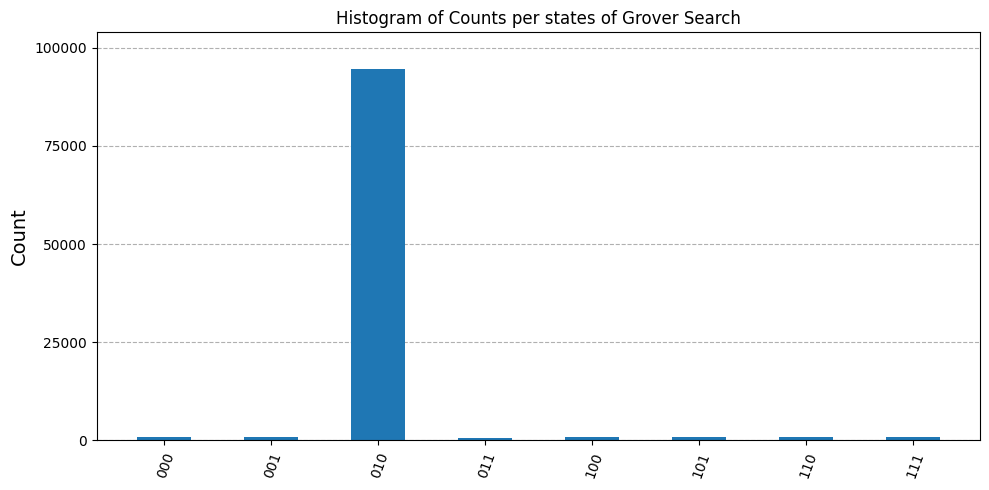

In [34]:
# visualize the counts 
plot_histogram(counts, title='Histogram of Counts per states of Grover Search', figsize=(10, 5), bar_labels=False)